# Simulation of an epidemic model

### Markov model :
* $(x,y) \rightarrow (x+1,y)$ at rate $\mu x$ (births of susceptibles);
* $(x,y) \rightarrow (x-1,y+1)$ at rate $\beta x y$ (infections);
* $(x,y) \rightarrow (x,y-1)$ at rate $\gamma y$ (death of infections);

### Lotka - Volterra model associated 
First order deterministic approximation:
\begin{align}
  d x_t = \mu x_t - \beta x_t y_t \\
  d y_t = \beta x_t y_t -\gamma y_t.
\end{align}

Fix point :
$$
  x_\star = \frac{\gamma}{\beta} \quad\text{and}\quad y_\star = \frac{\mu}{\beta}. 
$$

Conserve quantity:
\begin{equation}
  \beta(x+y) - \gamma \log(x) - \mu\log(y).
\end{equation}

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import matplotlib.mlab as mlab

import math

matplotlib.pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
# Scaling 
N = 10000
# Model parameters
mu = 1
gamma = 10.
beta = 0.1
# Fix point
xstar = gamma / beta
ystar = mu / beta
# Initial values
x0 = N
y0 = N

### Markov model renormalised :
* $(x,y) \rightarrow (x+\tfrac{1}{N},y)$ at rate $\mu x N$ (births of susceptibles);
* $(x,y) \rightarrow (x-\tfrac{1}{N},y+\tfrac{1}{N})$ at rate $\beta' x y N$ (infections);
* $(x,y) \rightarrow (x,y-\tfrac{1}{N})$ at rate $\gamma y N$ (death of infections);

where the $\beta' = \beta N$.

In [3]:
import random
import time

# Model next step.
def model_next_step(t, x, y):
    random.seed(time.time())
    t_arrival = random.expovariate(mu*x)
    t_infection = random.expovariate(beta*x*y)
    t_death = random.expovariate(gamma*y)
    
    if t_arrival <= t_infection and t_arrival <= t_death:
        return (t+t_arrival, x+1, y)
    elif t_infection <= t_death:
        return (t+t_infection, x-1, y+1)
    else:
        return (t+t_death, x, y-1)
    
# Simulation of the model
def simulate_model(_x0, _y0):
    vt = np.array([0.])
    vx = np.array([_x0])
    vy = np.array([_y0])
    
    (t, x, y) = model_next_step(vt[-1], vx[-1], vy[-1])
    while x > 0 and y > 0:
        vt = np.append(vt, t)
        vx = np.append(vx, x)
        vy = np.append(vy, y)
        (t, x, y) = model_next_step(vt[-1], vx[-1], vy[-1])
    
    return (vt, vx, vy)

In [4]:
# Compute conserve quantity
def f_cons_qty(x, y):
    return beta * (x+y) - gamma*math.log(x) - mu*math.log(y)
vf_cons_qty = np.vectorize(f_cons_qty)

In [5]:
# Make a few simulations.
nb = 1
N = 100
x0 = 2*int(N * xstar)
y0 = int(N * ystar)
(vt, vx, vy) = simulate_model(x0, y0)

In [8]:
# Plotting grid
xdelta = xstar * 0.01
ydelta = ystar * 0.01
xmax = xstar * 10
ymax = ystar * 10
x = np.arange(xdelta, xmax, xdelta)
y = np.arange(ydelta, ymax, ydelta)
X, Y = np.meshgrid(x, y)

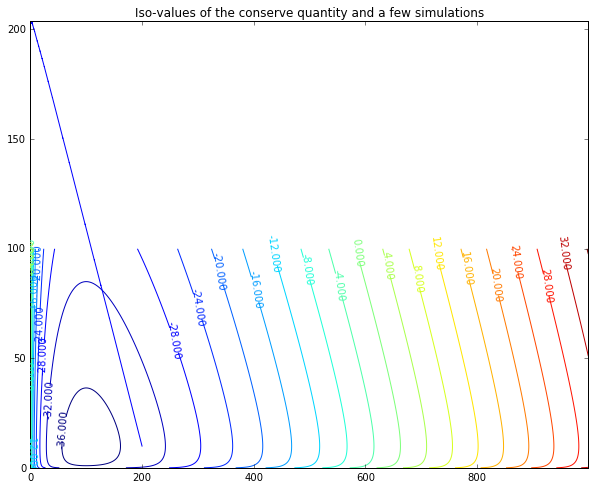

In [9]:
# Plotting initialisation
plt.figure()

# Plot conserve quantity of the Lotka--Volterra model
nlines = 20
cons_qty = vf_cons_qty(X, Y)
cs_cons_qty = plt.contour(X, Y, cons_qty, nlines)
plt.clabel(cs_cons_qty, inline=1, fontsize=10)

# Plot simulation
plt.plot(vx / N, vy / N)
# plt.plot(np.array([xstar,10,5]), np.array([ystar,10,10]))

# Final plot
plt.title('Iso-values of the conserve quantity and a few simulations')
plt.show()

In [ ]:
# Pot pourri
# line_colours = ('BlueViolet', 'Crimson', 'ForestGreen', 'Indigo', 'Tomato', 'Maroon')
# line_widths = (1, 1.5, 2, 2.5, 3, 3.5)
# plt.scatter(xstar, ystar, marker='o', c='b', s=40)
# plt.scatter([xstar,10], [ystar,10], marker='o', c='b', s=40, linewidths=1)
# plt.plot(np.array([xstar,10,5]), np.array([ystar,10,10]))
